## Combining all downstream used A2TEA data into one RDS object
## Also performing necessary data manipulation

In [188]:
###packages currently installed via conda

#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install(version = "3.12")

#BiocManager::install("DESeq2")
#BiocManager::install("ggtree")
#BiocManager::install("Biostrings")

#lfcShrinkage isn't installable at the moment - problem for later
#install.packages("mvtnorm")
#BiocManager::install("apeglm")

#install.packages("data.table")

#install.packages("seqinr")
#install.packages("VennDiagram")
#install.packages("UpSetR")
#install.packages("cowplot")
#install.packages("ggplotify")

also installing the dependency ‘gridGraphics’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
library(DESeq2)
#library(BiocGenerics) # comes with DESeq2
#library(apeglm) # currently difficulties with install # better DESseq2 calc; later 

library(tidyverse)
#library(data.table) #actually not necessary
library(ggtree)
library(Biostrings)
library(seqinr)
library(VennDiagram)
library(UpSetR)
library(cowplot)
library(ggplotify)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

#### Find all DESeq2 differential expression RDS objects and load them
##### Names are given based on the species/ecotype/etc. name

In [2]:
dea_list <- list.files(path = "R/deseq2/dea_final/", pattern = "dea_*", full.names=TRUE)
dea_list_short <- list.files(path = "R/deseq2/dea_final/", pattern = "dea_*", full.names=FALSE)

#species <- str_sub(dea_list_short[[1]], start=5)

#lapply(dea_list_short, str_sub(start=5))


listRDS <- lapply(dea_list, readRDS, .GlobalEnv)


for (i in 1:length(listRDS)){
    assign(str_sub(dea_list_short[[i]], start=5), listRDS[[i]])
}

#remove unused combined list object
#rm(listRDS)

In [4]:
#nice for later - but needs install of package "apeglm"

#link on logFC shrinking
#https://support.bioconductor.org/p/77461/
#?lfcShrink
#lfcShrink(arabidopsis_dea, coef=2, type="apeglm")
#resultsNames(arabidopsis_dea)

Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  ..@ design            :Class 'formula'  language ~condition
  .. .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
  ..@ dispersionFunction:function (q)  
  .. ..- attr(*, "coefficients")= Named num [1:2] 0.0156 2.5109
  .. .. ..- attr(*, "names")= chr [1:2] "asymptDisp" "extraPois"
  .. ..- attr(*, "fitType")= chr "parametric"
  .. ..- attr(*, "varLogDispEsts")= num 1.11
  .. ..- attr(*, "dispPriorVar")= num 0.621
  ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. ..@ ranges  

In [3]:
# DESeq2 testing
#At <- readRDS("R/deseq2/dea_final/dea_Arabidopsis_thaliana")
#DESeq2::results(At)
#as.data.frame(results(Arabidopsis_thaliana))

log2 fold change (MLE): condition treatment vs control 
Wald test p-value: condition treatment vs control 
DataFrame with 27655 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
AT1G01010   41.1955     -0.1421724  0.263433 -0.539692  0.589410  0.999925
AT1G01020  248.8242      0.0482747  0.224740  0.214802  0.829921  0.999925
AT1G01030   98.5577      0.1553281  0.241567  0.643002  0.520223  0.999925
AT1G01040  349.2899      0.1578706  0.210779  0.748987  0.453865  0.999925
AT1G01050  490.8870     -0.0106010  0.181511 -0.058404  0.953427  0.999925
...             ...            ...       ...       ...       ...       ...
ATMG01350  0.846627      -0.865725   2.29284 -0.377578  0.705744  0.999925
ATMG01360 34.264385       0.269654   0.98383  0.274086  0.784019  0.999925
ATMG01370  4.166537       0.530110   1.04153  0.508973  0.610771  0.999925
ATMG01400  0.139878       1.

In [3]:
species_list <- vector()

for (i in 1:length(dea_list_short)){
    species_list <- c(species_list, str_sub(dea_list_short[[i]], start=5))
}

list_AllSpeciesDEResultsDataFrames <- list()

for (i in species_list) {
    # individual species file could be deleted but perhaps I'll need them later; kept for now...
    assign(paste0(i, "_DEresultsTable"), as.data.frame(results(get(i))))
    # create gene name vector here (when list is constructed rownames become unique species-gene combination)
    gene <- rownames(get(paste0(i, "_DEresultsTable")))
    df_with_genes <- add_column(get(paste0(i, "_DEresultsTable")), gene, .before = "baseMean")
    # also add a species column which will will also come in handy during the shiny steps
    species <- replicate(nrow(df_with_genes), i)
    df_with_genes <- add_column(df_with_genes, species, .before = "gene")
    # create list of dataframes, which will come in handy
    list_AllSpeciesDEResultsDataFrames[[i]] <- df_with_genes
    # list_AllSpeciesDEResultsDataFrames[[i]] <- (get(paste0(i, "_DEresultsTable")))
}

#str(list_AllSpeciesDEResultsDataFrames)

#create combined "mega" dataframe of all species, which is going  to be used for shiny lookup

combined_AllSpeciesDEResultsDataFrames <- do.call("rbind", list_AllSpeciesDEResultsDataFrames)


#str(combined_AllSpeciesDEResultsDataFrames)
#head(combined_AllSpeciesDEResultsDataFrames)
#head(list_AllSpeciesDEResultsDataFrames[[1]])
#?rbind

### creating long format HOG-genes relation table

In [4]:
HOG_file_raw <- read_delim("orthofinder/final-results/Phylogenetic_Hierarchical_Orthogroups/N0.tsv", delim = "\t")

#drop the OG, Gene Tree Parent Clade
HOG_file_short <- HOG_file_raw %>% select (-c(OG, `Gene Tree Parent Clade`)) 


#merge all species columns into one and remove the solo ones
#use all colnames except first - thus all species
HOG_file_merged <- HOG_file_short %>% unite(x,
                                          c(colnames(HOG_file_short)[-1]),
                                          sep = ",", 
                                          na.rm = TRUE,
                                          remove = TRUE)

#transform into long format - each row 1 gene and it's corresponding HOG in seperate columns
HOG_file_long <- HOG_file_merged %>%
                    mutate(unpacked = str_split(x, ",")) %>%
                    unnest(cols = c(unpacked)) %>%
                    mutate(genes = str_trim(unpacked)) %>% 
                    select(-c(x, unpacked)) %>% 
                    rename(gene = genes)

str(HOG_file_long)


── Column specification ──────────────────────────────────────────────────────
cols(
  HOG = col_character(),
  OG = col_character(),
  `Gene Tree Parent Clade` = col_character(),
  Arabidopsis_thaliana = col_character(),
  Hordeum_vulgare = col_character(),
  Zea_mays = col_character()
)




tibble [90,454 × 2] (S3: tbl_df/tbl/data.frame)
 $ HOG : chr [1:90454] "N0.HOG0000000" "N0.HOG0000000" "N0.HOG0000000" "N0.HOG0000000" ...
 $ gene: chr [1:90454] "Zm00001d020494" "Zm00001d007563" "Zm00001d052359" "Zm00001d037178" ...


### adding specific HOG or singleton info as HOG column to DE tables

In [5]:
#?full_join
HOG_DE.a2tea <- full_join(combined_AllSpeciesDEResultsDataFrames, HOG_file_long, 
              by = c("gene")) %>% 
                replace_na(list(HOG = "singleton"))

#add column for significance - default level is padj <= 0.1

#subset tidyverse with the right functions ;D
#filter(HOG_DE.a2tea, padj < 0.05)
#?drop_na

significant <- vector()
for (FDR in HOG_DE.a2tea$padj) {
    if (!is.na(FDR) && FDR < 0.1) {
        significant <- c(significant, "yes")
    }
    else if (!is.na(FDR) && FDR > 0.1) {
        significant <- c(significant, "no")
    }
    else if (is.na(FDR)) {
        significant <- c(significant, "no")
    }
}

HOG_DE.a2tea <- add_column(HOG_DE.a2tea, significant, .after = "padj")

In [164]:
#?full_join

### load in the rest of the data - hypotheses, trees, fasta and msa for the start 
### + toDo general stats, especially once Orthofinder calculates for HOG)
### +toDo Venn DIagrammes (until 5 species or so then alternative plots)

In [170]:
hypotheses <- read_delim("hypotheses.tsv", delim = "\t")


#create hypotheses object
# each object has list of exp. OGs
#iterate over list of hyptheses and associate expansions, fasta, msa and trees


#first goal - hypothesis object with hypothesis and all exp.HOGs

#could do it over objects in tea directory
#list.files(path = "tea", pattern = "*", full.names=FALSE)


#alternatively via parsing of hyptheses.tsv
hypotheses$hypothesis


## define two classes
# class for the expanded_OG - containing all different types of data we have on it
setClass("expanded_OG", slots=list(genes="spec_tbl_df", 
                                  fasta_files="list", 
                                  msa="AAMultipleAlignment", 
                                  tree="phylo"))


# class for the hypotheses
# adding a prototype is essential here for ortho_intersect_plot since gg has to be defined as 
# register an old-style S3 class using setOldClass
#https://stackoverflow.com/questions/12636056/why-sometimes-i-cant-set-a-class-definition-as-slot-in-a-s4-class
#https://stackoverflow.com/questions/13841400/use-s3-virtual-class-as-slot-of-an-s4-class-got-error-got-class-s4-should-b
#had trouble getting this to work; thus solved differently
# -> seperate list object "Ortho_intersect_plots" hypothesis specific access via index
setClass("hypothesis", 
#         prototype=prototype(ortho_intersect_plot=structure(list(), class="gList")),
         slots=list(description="character", 
                                  number="character",
                                  expanded_in ="character", 
                                  compared_to="character", 
                                  expanded_OGs="list"))
#                                  ortho_intersect_plot="gg"))




rm(t)
rm(hypothesis_1)
rm(hypothesis_2)
rm(HYPOTHESES.a2tea)


#remove protein_names in the snakemake pipeline - directories clean enough


for (hypothesis in hypotheses$hypothesis) {
    # print(paste0("hypothesis_", hypo))
    
    # create empty list object for hypothesis #
    assign(paste0("hypothesis_", hypothesis), list())

    # assign list of names
    expanded_OGs <- list.files(path = paste0("tea/", hypothesis, "/exp_OGs_proteinnames/"), 
                               pattern = "*", 
                               full.names=FALSE)
    expanded_OGs_short <- str_sub(expanded_OGs, end=-5)


    #create empty list
    t <- list()

    for (exp_OG in expanded_OGs_short) {
    # print(exp_OG)
        test <- new("expanded_OG", 
             genes=read_table(paste0("tea/", hypothesis, "/exp_OGs_proteinnames/", exp_OG, ".txt")), 
             fasta_files=read.fasta(paste0("tea/", hypothesis, "/fa_records/", exp_OG,".fa"), seqtype = "AA", as.string = TRUE), 
             msa=readAAMultipleAlignment(paste0("tea/", hypothesis, "/muscle/", exp_OG, ".afa")), 
             tree=read.tree(paste0("tea/", hypothesis, "/trees/", exp_OG, ".tree")))
   
        x <- list(test)
        names(x) <- paste0(exp_OG)
        t <- c(t, x)
    }
 
    # create for each hypothesis a complete hypothesis object with correct naming
    # order: hypothesis@info (name, number, expand, compared, exp OGs)$indiv. exp_OGs@objects (exp.OG list, fa, msa, tree)
    # "expanded_in" and "compared_to" are split on ";" in case their size is > 1
    assign(paste0("hypothesis_", hypothesis),
              new("hypothesis", 
                  description=hypotheses$name[hypothesis],
                  number=as.character(hypothesis),
                  expanded_in=unlist(str_split(hypotheses$expanded_in[hypothesis], ";")),
                  compared_to=unlist(str_split(hypotheses$compared_to[hypothesis], ";")), 
                  expanded_OGs=t))#,
#                  ortho_intersect_plot=NULL))
}


# create empty list for final complete hypothesis object

#rm

# create name list of all hypotheses
hypotheses_list <- ls(pattern = "hypothesis_")

# create empty list object to completely hold all hypotheses and associated data
HYPOTHESES.a2tea <- list()

for (hypothesis in hypotheses_list) {
    h <- list(get(hypothesis))
    names(h) <- paste0(hypothesis)
    HYPOTHESES.a2tea <- c(HYPOTHESES.a2tea, h)
}

rm(hypothesis_1)
rm(hypothesis_2)


# final object is called:
# HYPOTHESES.a2tea


#add expanded OGs as column
#    add_column(get(paste0("hypothesis_", hypo)), expanded_OGs)
#class(hypothesis_1@expanded_OGs) <- c("expanded_OG", class(hypothesis_1@expanded_OGs))



── Column specification ──────────────────────────────────────────────────────
cols(
  hypothesis = col_double(),
  name = col_character(),
  expanded_in = col_character(),
  compared_to = col_character()
)




[1] 1 2

Warning message in rm(hypothesis_2):
“object 'hypothesis_2' not found”
Warning message in rm(HYPOTHESES.a2tea):
“object 'HYPOTHESES.a2tea' not found”

── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G53750 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT2G18640 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT5G64110 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d007084 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU1Hr1G050070 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G28660 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d026010 = col_character


── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G16410 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d048868 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G29250 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d041988 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT4G15320 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU4Hr1G082390 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G07620 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d021309 = col_character()
)



── Column specifi


── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU2Hr1G072400 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT5G40400 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT4G07400 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU7Hr1G088260 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT1G65880 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU4Hr1G066000 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU4Hr1G009800 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d021846 = col_character()
)



── Col


── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU5Hr1G056030 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d047282 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT5G43980 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G58750 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d047790 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU4Hr1G054770 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d051884 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  Zm00001d032077 = col_character()
)



── Co


── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU1Hr1G004980 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU7Hr1G076580 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT5G16680 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT5G09730 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT1G10050 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU7Hr1G076050 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G57880 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU1Hr1G021780 = col_character()
)



── Column s


── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU7Hr1G008390 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU2Hr1G101670 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT1G47240 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT2G17990 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT1G43630 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT1G27990 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  HORVU6Hr1G066740 = col_character()
)



── Column specification ──────────────────────────────────────────────────────
cols(
  AT3G25620 = col_character()
)



── Column specific

ERROR: Error in validObject(.Object): invalid class “hypothesis” object: invalid object for slot "ortho_intersect_plot" in class "hypothesis": got class "S4", should be or extend class "gg"


In [53]:
length(hypotheses$hypothesis)
#?setClass

[1] 2

### HOG level tables -needs to be behind creation of hypotheses, because they are used here

In [17]:
# create hypothesis specfic HOG level file

#find all tibbles -list
#list.files(path = "tea/1/expansion_tibble", pattern = "expansion_tibble.rds", full.names=TRUE)


#length(hypotheses_list)


HOG_level_list <- list()

#for (i in 1:length(hypotheses_list)) {
for (i in 1:length(hypotheses$hypothesis)) {
    assign(paste0("hypothesis_", i, "_expansion_tibble"),
           readRDS(
               list.files(path = paste0("tea/", i, "/expansion_tibble"), 
                      pattern = "expansion_tibble.rds", 
                      full.names=TRUE)
                  )
           )
    # add to list and name list entries according to hypothesis
    hog_level <- list(get(paste0("hypothesis_", i, "_expansion_tibble")))
    names(hog_level) <- paste0("hypothesis_", i)
    HOG_level_list <- c(HOG_level_list, hog_level)
}

#e.g. the following displays the tibble
#hypothesis_2_expansion_tibble

#r
#append "_gene_count" to all species in HOG tables
#get number of significantly regulated genes per HOG (per species and total) 
# -> (hmm perhaps do this once and then merge?)


# get count of species, HOG, significant combination from HOG_DE.a2tea
# reduce it to HOG, species, count
sig_genes_per_species_and_HOG <- HOG_DE.a2tea %>% 
                                     filter(significant == c("yes")) %>%
                                     filter(HOG != c("singleton")) %>%
                                        group_by(HOG, species, significant) %>% 
                                        mutate(count = n()) %>%
                                        ungroup() %>%
                                        select(HOG, species, count) %>%
            # https://www.r-bloggers.com/2018/05/workaround-for-tidyrspread-with-duplicate-row-identifiers/
            # spread error when no indexing for data
                                            group_by(species) %>% 
                                            mutate(grouped_id = row_number()) %>%  
                                            spread(species, count) %>% 
                                            select(-grouped_id) %>%
            # easy workaround for duplicated rows
                                                distinct()%>% 
            # rename species columns containing now the counts of sig. DE genes
                                                    rename_at(vars(-HOG), ~ paste0(., '_sigDE'))
    # and also add a column summing the rowwise sig. DE counts for all species
    sig_genes_per_species_and_HOG %>% select(-HOG) %>% rowSums(na.rm=TRUE) -> total_sigDE
    sig_genes_per_species_and_HOG <- add_column(sig_genes_per_species_and_HOG, total_sigDE)

#sig_genes_per_species_and_HOG
#total_sigDE
#inner_join(HOG_level_list[[1]], sig_genes_per_species_and_HOG, by = c("HOG"))
#full_join important - better to keep all HOG rows and allow filtering dynamically in the WebAPP itself

for (i in 1:length(HOG_level_list)) {
    HOG_level_list[[i]] <- HOG_level_list[[i]] %>% rename_at(vars(-HOG, -expansion), ~ paste0(., '_total'))
    HOG_level_list[[i]] <- full_join(HOG_level_list[[i]], sig_genes_per_species_and_HOG, by = c("HOG"))
}

str(HOG_level_list)


#head(HOG_level_list)

#df %>% rename_at(vars(-Name, -State), ~ paste0(., '_2017'))


List of 2
 $ hypothesis_1: tibble [22,455 × 9] (S3: tbl_df/tbl/data.frame)
  ..$ HOG                       : chr [1:22455] "N0.HOG0000000" "N0.HOG0000001" "N0.HOG0000002" "N0.HOG0000003" ...
  ..$ Arabidopsis_thaliana_total: num [1:22455] 0 0 2 0 1 107 0 0 99 3 ...
  ..$ Zea_mays_total            : num [1:22455] 425 1 3 145 0 0 0 0 0 92 ...
  ..$ Hordeum_vulgare_total     : num [1:22455] 0 206 0 2 1 0 105 101 0 0 ...
  ..$ expansion                 : chr [1:22455] "no" "no" "no" "no" ...
  ..$ Arabidopsis_thaliana_sigDE: int [1:22455] NA NA NA NA NA NA NA NA NA NA ...
  ..$ Hordeum_vulgare_sigDE     : int [1:22455] NA 11 NA NA NA NA 1 1 NA NA ...
  ..$ Zea_mays_sigDE            : int [1:22455] NA NA NA NA NA NA NA NA NA NA ...
  ..$ total_sigDE               : num [1:22455] NA 11 NA NA NA NA 1 1 NA NA ...
 $ hypothesis_2: tibble [22,455 × 8] (S3: tbl_df/tbl/data.frame)
  ..$ HOG                       : chr [1:22455] "N0.HOG0000000" "N0.HOG0000001" "N0.HOG0000002" "N0.HOG0000003" ...
  

In [54]:
summary(HYPOTHESES.a2tea)

                              Length Class      Mode
hypothesis_1                  1      hypothesis S4  
hypothesis_1_expansion_tibble 5      tbl_df     list
hypothesis_2                  1      hypothesis S4  
hypothesis_2_expansion_tibble 4      tbl_df     list

### creating Venn (or alternative diagrammes for the hypothesis)

In [178]:
# create this awesome function to change area of plotting
# https://stackoverflow.com/questions/1279003/specify-width-and-height-of-plot
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }
# use funtion to set area a bit wider
set_plot_dimensions(32, 10)



#step 1: removing all species not in hypothesis or keep only those that are
# using HOG_level_list and looking at the "_total" columns
#  only species in this hypothesis are in here ;D
# -> still drop all columns not necessary?
#step 2: perform check on size of this set
# -> if < 5 then create Venn diagramme
# -> if > 5 then create alternative plot
# create plot and safe as sub element in HYPOTHESES.a2tea object 



#HOG_DE.a2tea
#HOG_level_list[[1]]
#choose based on set length 2,3,4,5 after that UpsetR


Ortho_intersect_plots <- list()

for (i in 1:length(HOG_level_list)) {

workset <-  HOG_level_list[[i]]
# drop columns that are unnecessary
workset <- workset %>% select(HOG, ends_with("_total")) 
# add this point we can easily compute the number of species/ecotypes etc. 
# #species = (columns of current workset - 1) 
species_num <- ncol(workset) - 1
# change 0 to NAs since we can more easily filter on that
is.na(workset) <- workset==0
# remove '_total' from column names
#str_remove(colnames(workset), "_total")
workset <- workset %>% setNames(names(workset) %>% stringr::str_replace("_total",""))

# for testing purposes - remove Genotype vectors
rm(Genotype1,Genotype2,Genotype3)

genotypeList <- list()
for (j in 1:species_num) {
    assign(paste0("Genotype", j), as.vector(simplify_all(workset[!is.na(workset[j+1]),"HOG"])[[1]]))
    subList <- list(get(paste0("Genotype", j)))
    names(subList) <- colnames(workset)[j+1]
    genotypeList <- c(genotypeList, subList)
}


#using UpSetR
upsetOrtho <- upset(fromList(genotypeList), 
                   order.by = "freq",
                   empty.intersections = "on",
                   point.size = 3.5, 
                   line.size = 2, 
                   mainbar.y.label = "HOG Intersections", 
                   text.scale = c(2, 1.3, 1, 1, 2, 2))

p <- upsetOrtho

# if we have less than 5 species draw a venn diagramme
# combine both plots with some trickery
if (species_num < 5) {
    
# draw venn diagramme
orthoVenn <- venn.diagram(genotypeList,
                           print.mode = c("raw","percent"),
                           sigdigs = 1,
                           filename = NULL,
                           category = names(genotypeList),
                           fill = rainbow(length(names(genotypeList))),
                           cat.col = rainbow(length(names(genotypeList))),
                           cat.cex = 2,
                           cex = 1.5,
                           margin = 0.05
                           )    
    
# as.grob from ggplotify is necessary
orthoIntersect <- plot_grid(orthoVenn, 
          as.grob(upsetOrtho), 
          rel_widths = c(1/3, 2/3))

#p <- ggplotify::as.ggplot(orthoIntersect)
p <- orthoIntersect
    }

Ortho_intersect_plots[[i]] <- p

}
    
    
    


Warning message in rm(Genotype1, Genotype2, Genotype3):
“object 'Genotype3' not found”


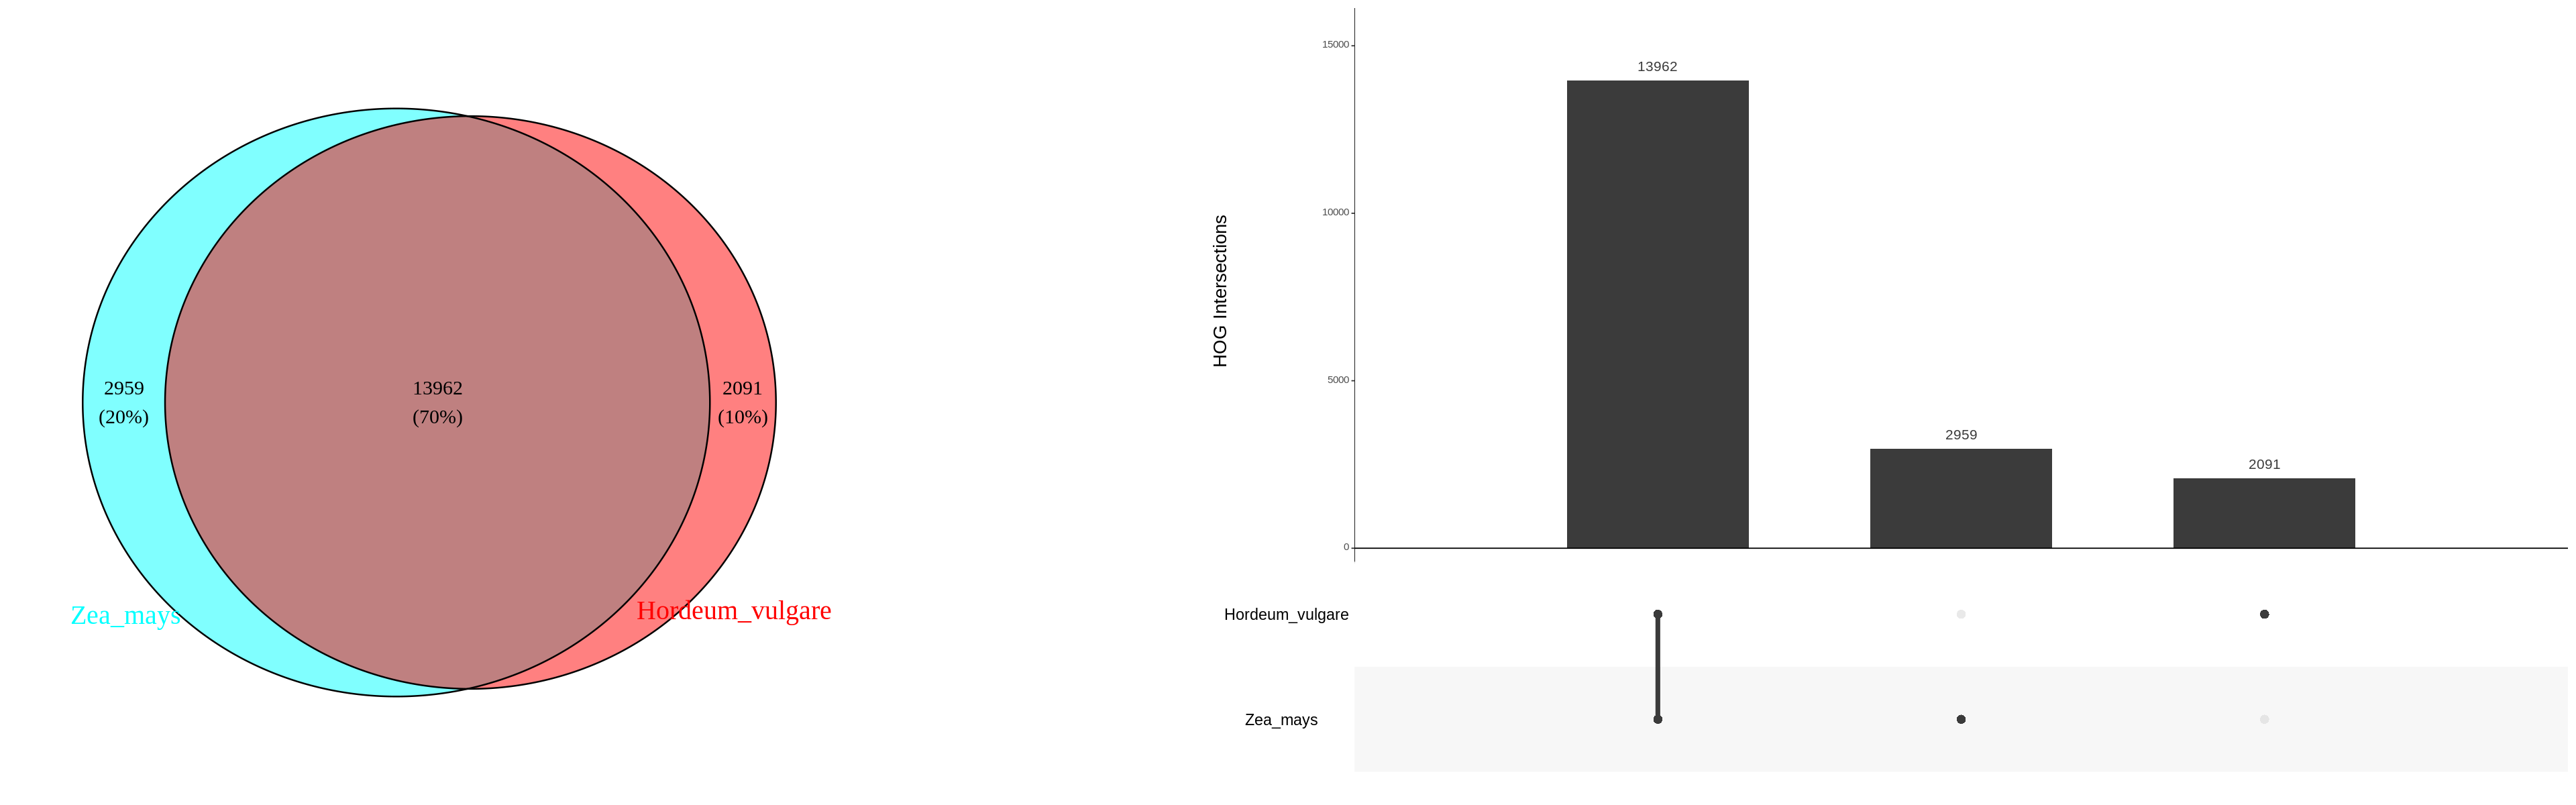

In [180]:
Ortho_intersect_plots[[2]]

### Last step: saving everything to one file which is input for the A2TEA WebApp

In [11]:
save(hypotheses, HYPOTHESES.a2tea, HOG_DE.a2tea, HOG_level_list, file = "tea/A2TEA_finished.RData")
# To load the data again
#load("tea/A2TEA_finished.RData")

#perhaps use this to name output based on time?
#paste0("tea/A2TEA_finished_",
#    str_replace_all(
#    str_replace_all(
#        Sys.time(), ":", "-"),
#    " ", "_"
#                    ), ".RData")